### 1. Import dependencies


In [1]:
import pandas as pd
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import pathlib
import time
import math
from math import atan2
from scipy.spatial import distance
import random

### 2. Functions

In [2]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

### 3. Import reference data to compare process

In [3]:
columns_df_2D_interest = ['RightShoulder_2D','RightShoulder_2D.1',
                          'RightElbow_2D', 'RightElbow_2D.1',
                          'RightHand_2D','RightHand_2D.1',
                          'LeftShoulder_2D','LeftShoulder_2D.1',
                          'LeftElbow_2D', 'LeftElbow_2D.1', 
                          'LeftHand_2D','LeftHand_2D.1']

columns_df_3D_interest = ['RightShoulder','RightShoulder.1','RightShoulder.2',
                          'RightElbow', 'RightElbow.1','RightElbow.2',
                          'RightHand','RightHand.1','RightHand.2',
                          'LeftShoulder','LeftShoulder.1','LeftShoulder.2',
                          'LeftElbow', 'LeftElbow.1', 'LeftElbow.2',
                          'LeftHand','LeftHand.1','LeftHand.2']

In [4]:
#For checking purposes
df_adri_Blender_RGSclinic_Kinect = pd.read_csv('../dataset/mocap_dataset/MocapCameraCoords/Dataset_MoCap_RGSclinic_KinectCamera.csv').drop(columns=['index_row'])[0:1311]
df_adri_Blender_RGSclinic_Kinect_3D = df_adri_Blender_RGSclinic_Kinect[columns_df_3D_interest]
df_adri_Blender_RGSclinic_Kinect_2D = df_adri_Blender_RGSclinic_Kinect[columns_df_2D_interest]

### 3. Get projection matrix - Zhang method
At least 10 images from different positions to obtain K, r and t for each chess board. K is common y all of them

In [5]:
#Chessboard variables
square_size = 0.043 #meters 
width_chessboard = 5
height_chessboard = 3

In [6]:
#termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((width_chessboard*height_chessboard,3), np.float32) #9x6 np.zeros array
objp[:,:2] = np.mgrid[0:width_chessboard,0:height_chessboard].T.reshape(-1,2)
objp = objp * square_size


images = glob('./images/*.jpg')

objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane
processed_images = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    
    ret, corners = cv2.findChessboardCorners(gray, (width_chessboard,height_chessboard), None)
    
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (width_chessboard,height_chessboard), corners2, ret)
        cv2.imshow('img', img)
        processed_images.append(img)
        time.sleep(2)
        if cv2.waitKey(500) and 0xFF==ord('q'):
            break
            
cv2.destroyAllWindows()

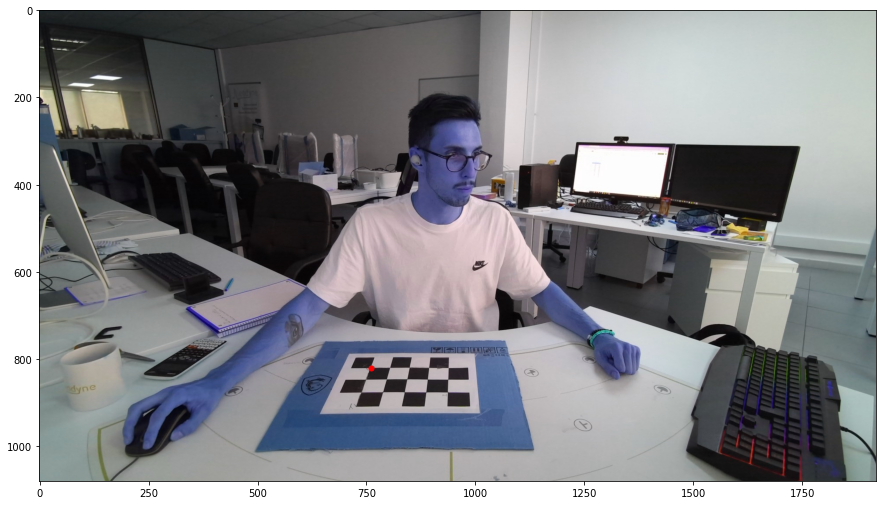

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.imread('./images/WIN_20220609_16_25_42_Pro (2).jpg'))
plt.scatter(imgpoints[0][0][0][0],imgpoints[0][0][0][1], color='red', s=25) #ORIGIN

In [7]:
#compute intrinsic parameter matrix and rvecs and tvecs for each picture
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [8]:
#Matrix intrinsic parameters
mtx

array([[915.30280471,   0.        , 919.16387661],
       [  0.        , 916.17325027, 552.28006073],
       [  0.        ,   0.        ,   1.        ]])

In [9]:
#Not considering distortion coefficients
dist_coeffs = np.zeros((5,1))

#Obtaining the rvecs and tvecs for the specific image with the origin in the World Origin
found, rvecs_new, tvecs_new = cv2.solvePnP(objpoints[0],imgpoints[0], mtx, dist_coeffs)

In [10]:
#Rotation matrix
R = cv2.Rodrigues(rvecs_new)[0]
R

array([[-0.99117975, -0.13238569, -0.00606057],
       [ 0.03282028, -0.28952069,  0.95660891],
       [-0.12839599,  0.94797247,  0.29131198]])

In [11]:
tvecs_new

array([[0.44341367],
       [0.32402721],
       [0.65532748]])

In [12]:
#Tilt angle
roll = atan2(R[1,2], R[2,2])
roll = 90-((roll*360)/(2*np.pi))
roll

16.761357575248823

In [13]:
h1 = float(tvecs_new[1]/np.cos(np.deg2rad(roll)))
h2 = float(tvecs_new[2]*np.cos(np.deg2rad(90-roll)))
H = h1+h2
i = float(tvecs_new[2]*np.cos(np.deg2rad(roll)))
d = float(tvecs_new[0])

In [14]:
final_tvecs = np.array([d, i, H])
final_tvecs

array([0.6486542 , 0.74742003, 0.52609459])

### 3D coordinates WorldFrame2CameraFrame

In [20]:
#Projection matrix
P = np.append(R, final_tvecs.reshape(3,1), axis=1) 
new_row = np.array([0.0, 0.0, 0.0, 1.0]).reshape(1,4)
#Converting P in a 4x4 matrix
P = np.append(P, new_row, axis=0)
#Computing camera matrix inverted
cam_matrix_inverted = np.linalg.inv(P)

In [21]:
#WorldCoordinates dataframe 2 convert
df_WorldOrigin = pd.read_csv('../dataset/mocap_dataset/Mocap2Worldcoords/Concatenated/Dataset_MoCap_WorldOrigin.csv', header=None)
df_Camera_origin_list_3D = []
df_Camera_projection_list_2D = []

for i in range(0,len(df_WorldOrigin[0:1311])): #Adri
    coordinates_row_3D = []
    coordinates_row_2D = []
    for j in range(0,len(df_WorldOrigin.iloc[i])):
        
        #########
        ###3D####
        #########
        
        #World Origin keypoint coordinates
        kp_coords  = [float(x) for x in df_WorldOrigin.iloc[i][j].strip(')(').split(',')] 
        #Invierto x para que esté igual a los ejes de camera calibration --> Mateixa disposició d'eixos que calibration cam
        kp_coords[0] = -kp_coords[0] 
        
        #Transformo al camera frame les coordenades X,Y,Z del WorldOrigin representades al calibration origin
        coords_3D = cam_matrix_inverted@np.append(kp_coords, 1.0).reshape(4,1) 
        
        #Invierto todo, pero ahora la X apuntaria en el sentido contrario a Kinect Frame
        coords_3D = -coords_3D[0:-1] 
        #Ara tot apunta com els eixos de la Kinect
        coords_3D[0] = -coords_3D[0] 
        
        #Unsplitting
        coordinates_row_3D.append(coords_3D[0])
        coordinates_row_3D.append(coords_3D[1])
        coordinates_row_3D.append(coords_3D[2])
        
        
        #########
        ###2D####  ---> ¡¡¡ES EL QUE FALTA!!!!!
        
        
        fx = mtx[0][0]
        fy = mtx[1][1]
        cx = mtx[0][2]
        cy = mtx[1][2]
    
        x_ = coords_3D[0]/coords_3D[2]
        y_ = coords_3D[1]/coords_3D[2]
        u = fx * x_ + cx
        v = 1-(fy * y_) + cy
        
        #########
#         coords_2d, b = cv2.projectPoints(np.array(kp_coords), rvecs_new, tvecs_new, mtx, dist_coeffs)
        
#         coords_2d, b = cv2.projectPoints(np.array(kp_coords), rvecs_new, np.array([tvecs_new[0][0], tvecs_new[2][0], tvecs_new[1][0]]), mtx, dist_coeffs) 
#         coords_2d, b = cv2.projectPoints(np.array(kp_coords), np.array([rvecs_new[0][0], rvecs_new[1][0], rvecs_new[2][0]]), np.array([tvecs_new[0][0], tvecs_new[1][0], tvecs_new[2][0]]), mtx, dist_coeffs) 
#         coords_2d, b = cv2.projectPoints(np.array(kp_coords), rvecs_new, final_tvecs, mtx, dist_coeffs)
#         coords_2d, b = cv2.projectPoints(np.array(kp_coords), np.array([rvecs_new[0][0], rvecs_new[1][0], rvecs_new[2][0]]), np.array([final_tvecs[0], final_tvecs[2], final_tvecs[1]]), mtx, dist_coeffs)
        
#         coords_2d_width = coords_2d[0][0][0]
#         coords_2d_height = 1080-coords_2d[0][0][1]

        #output= mtx@np.append(R, final_tvecs.reshape(3,1), axis=1)@np.append(np.array(kp_coords),1.0).reshape(4,1)
        #output= mtx@np.append(R, tvecs_new.reshape(3,1), axis=1)@np.append(np.array(kp_coords),1.0).reshape(4,1)
    
        coordinates_row_2D.append(u)
        coordinates_row_2D.append(v)
        
        #coordinates_row_2D.append(coords_2d_width)
        #coordinates_row_2D.append(coords_2d_height)
        
    df_Camera_origin_list_3D.append(pd.DataFrame(coordinates_row_3D).T)
    df_Camera_projection_list_2D.append(pd.DataFrame(coordinates_row_2D).T)
    
df_CameraOrigin_3D = pd.concat(df_Camera_origin_list_3D).rename(columns=dict(enumerate(columns_df_3D_interest)))
df_CameraProjection_2D = pd.concat(df_Camera_projection_list_2D).rename(columns=dict(enumerate(columns_df_2D_interest)))

In [22]:
df_CameraOrigin_3D.head(5)

,RightShoulder,RightShoulder.1,RightShoulder.2,RightElbow,RightElbow.1,RightElbow.2,RightHand,RightHand.1,RightHand.2,LeftShoulder,LeftShoulder.1,LeftShoulder.2,LeftElbow,LeftElbow.1,LeftElbow.2,LeftHand,LeftHand.1,LeftHand.2
0,-0.307659,0.379494,1.336592,-0.516127,0.267921,1.530346,-0.462107,0.103478,1.322195,0.056756,0.425003,1.346988,0.240835,0.317513,1.564643,0.220190,0.129090,1.370641
0,-0.307042,0.382122,1.345293,-0.516064,0.263711,1.533222,-0.463105,0.103441,1.322162,0.058303,0.427529,1.357953,0.239781,0.310616,1.574041,0.219034,0.129693,1.374678
0,-0.306401,0.385280,1.352683,-0.516090,0.261731,1.536235,-0.463150,0.103831,1.323082,0.059894,0.428214,1.369700,0.236707,0.303115,1.584685,0.217922,0.129906,1.377796
0,-0.304695,0.387165,1.359578,-0.515116,0.259788,1.539281,-0.463174,0.103301,1.324393,0.061462,0.428370,1.382759,0.234764,0.293031,1.594304,0.213861,0.131068,1.378193
0,-0.302966,0.389580,1.365162,-0.515073,0.257948,1.540064,-0.463150,0.103831,1.323082,0.063118,0.427745,1.393977,0.232044,0.279509,1.600995,0.205894,0.131300,1.376619


In [23]:
df_CameraProjection_2D .head(5)

,RightShoulder_2D,RightShoulder_2D.1,RightElbow_2D,RightElbow_2D.1,RightHand_2D,RightHand_2D.1,LeftShoulder_2D,LeftShoulder_2D.1,LeftElbow_2D,LeftElbow_2D.1,LeftHand_2D,LeftHand_2D.1
0,716.028878,306.965972,617.148353,407.120689,605.847416,496.192971,967.493397,277.896470,1070.721233,381.489419,1076.930902,481.545658
0,717.827364,306.858195,617.770071,409.949249,605.141840,496.217074,968.231815,278.529376,1069.254648,386.635613,1075.718410,481.396435
0,719.416144,306.137973,618.364498,411.445419,605.335421,495.995831,968.964202,280.553313,1066.518452,392.210280,1074.640433,481.450551
0,721.635303,306.191229,619.562372,412.916804,605.639105,496.435447,969.629566,283.166260,1064.560772,399.091745,1071.877208,480.700265
0,723.651245,305.635241,619.745073,414.095003,605.335421,495.995831,970.396816,285.872559,1062.423715,407.569315,1066.696949,480.445004


#### Checking 3D output

In [20]:
index = random.randint(0,len(df_CameraOrigin_3D)-1)
index

352

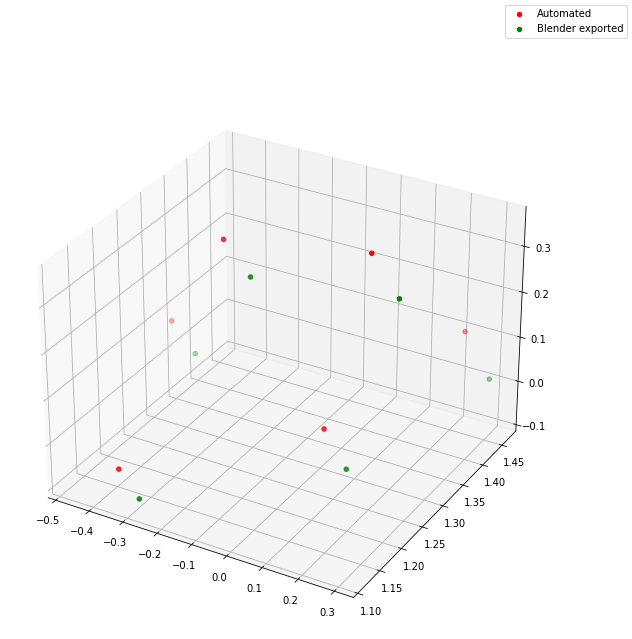

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_CameraOrigin_3D))).iloc[index]))[:,0],np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_CameraOrigin_3D))).iloc[index]))[:,2], np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_CameraOrigin_3D))).iloc[index]))[:,1], c='red',label='Automated')
ax.scatter(np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_3D))).iloc[index]))[:,0],np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_CameraOrigin_3D))).iloc[index]))[:,2], np.array(list(pd.DataFrame(split_3_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_3D))).iloc[index]))[:,1], c='green',label='Blender exported')
fig.legend()

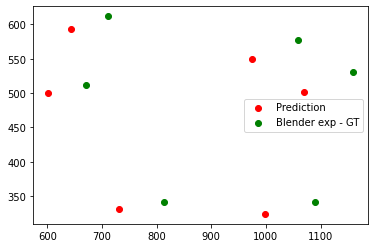

In [22]:
plt.scatter(np.array(list(pd.DataFrame(list(split_2_coordinates(np.array(df_CameraProjection_2D)))).iloc[index]))[:,0],np.array(list(pd.DataFrame(list(split_2_coordinates(np.array(df_CameraProjection_2D)))).iloc[index]))[:,1], color='red', label='Prediction')
plt.scatter(np.array(list(pd.DataFrame(list(split_2_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_2D)))).iloc[index]))[:,0],np.array(list(pd.DataFrame(list(split_2_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_2D)))).iloc[index]))[:,1], color='green', label='Blender exp - GT')
plt.legend()

### Checking performance of the calibration, translation & projection procedures -- comparing with Adri data 1311 rows

###### MPJPE entre lo que calibra y traduce a camera frame y la realidad (Blender)

In [77]:
df_adri_Blender_RGSclinic_Kinect_3D_splitted = pd.DataFrame(split_3_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_3D)))
df_adri_CameraOrigin = pd.DataFrame(split_3_coordinates(np.array(df_CameraOrigin_3D)))[0:1311]

In [78]:
all_distances = []
for keypoint in np.arange(0,6):
    keypoint_distances = []
    for i in range(0,len(df_adri_Blender_RGSclinic_Kinect_3D_splitted[keypoint])):
        keypoint_distances.append(distance.euclidean(df_adri_Blender_RGSclinic_Kinect_3D_splitted[keypoint][i], df_adri_CameraOrigin[keypoint][i]))
    all_distances.append(keypoint_distances)
df_PJPE = pd.DataFrame(all_distances).T

In [79]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

The obtained MPJPE error is: 100.27493321265835mm


###### Compute PCK between GT and calibrated 2D 

In [80]:
df_pred_2D_splitted = pd.DataFrame(split_2_coordinates(np.array(df_CameraProjection_2D)))[0:1311]
df_gt_2D_splitted = pd.DataFrame(split_2_coordinates(np.array(df_adri_Blender_RGSclinic_Kinect_2D)))

In [81]:
#Compute the euclidean distance for each keypoint between the ground truth and the prediction
all_distances = []
#For each keypoint
for i in range(0,df_pred_2D_splitted.shape[1]):
    keypoint_distances = []
    for j in range(0,len(df_gt_2D_splitted[i])):
        try:
            keypoint_distances.append(distance.euclidean(df_gt_2D_splitted[i][j], df_pred_2D_splitted[i][j]))
        
        except Exception as e: 
            print(j)
            print(e)
            pass
    all_distances.append(keypoint_distances)

df_ED = pd.DataFrame(all_distances).T

In [84]:
#150 pixels is the head bone link of the woman virtual character. (Head-bone link --> Des de el entrecejo hasta inicio columna)
threshold = 0.5*200

#Se calcula PCK por cada imágen y luego se hace la media

PCK_per_image = []
#For each image
for i in range(0,len(df_ED)):
    condition = []
    #For each euclidean distance computed, if the ED is below a certain treshold, consider it good(1.0), if not, consider it bad (0.0)
    for di in df_ED.iloc[i]:
        condition.append(di < threshold)
    PCK_per_image.append(sum(condition)/6)
        
        
PCK = sum(PCK_per_image)/len(PCK_per_image)
print('The PCK@0.5 for the MediaPipe Detections is: '+str(PCK))

The PCK@0.5 for the MediaPipe Detections is: 1.0
